In [1]:
# ---- Importing the required libraries ----
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import matthews_corrcoef
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from utils.resources_monitor import monitor_tic, monitor_toc
from utils.energy_simulator import simulate_energy_consumption
from utils.xai_methods import *

# setting seeds
global_random_seed = 42
np.random.seed(global_random_seed)

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
# ---- Setup ----

# model setup
DT = DecisionTreeClassifier(random_state=global_random_seed)
KNN = KNeighborsClassifier()

# xai setup
PI = permutation_importance_explanation
SHAP = shap_explanation

# loading dataset
dataset = pd.read_csv("../datasets/iris.csv")

dataset.head(10)

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa
5,5.4,3.9,1.7,0.4,setosa
6,4.6,3.4,1.4,0.3,setosa
7,5.0,3.4,1.5,0.2,setosa
8,4.4,2.9,1.4,0.2,setosa
9,4.9,3.1,1.5,0.1,setosa


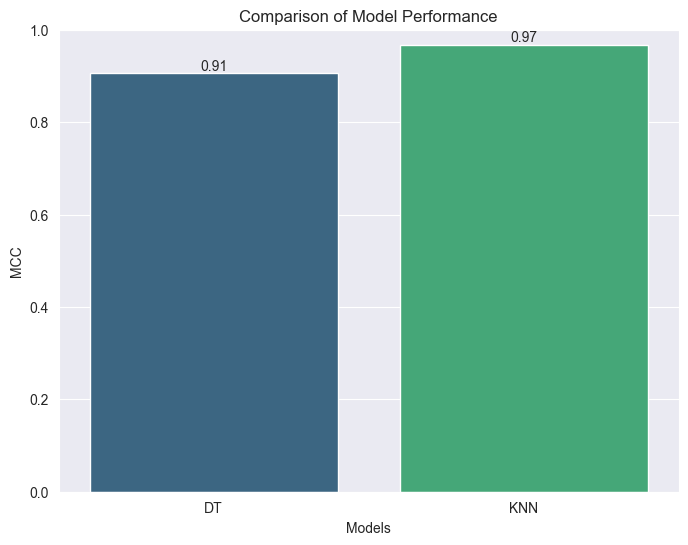

In [3]:
# ---- Training and testing the ML models----

# splitting features & label
X = dataset.drop('species', axis=1)
y = dataset['species']
y, _  = pd.factorize(y)

# splitting the dataset in train and test
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=global_random_seed, stratify=y)

# training models
DT.fit(x_train, y_train)
KNN.fit(x_train, y_train)

# testing models
y_pred_1 = DT.predict(x_test)
y_pred_2 = KNN.predict(x_test)

mcc_1 = matthews_corrcoef(y_test, y_pred_1)
mcc_2 = matthews_corrcoef(y_test, y_pred_2)

# showing the MCC values
data = {
    'Model': ['DT', 'KNN'],
    'MCC': [mcc_1, mcc_2]
}
# Creating DataFrame
df = pd.DataFrame(data)
plt.figure(figsize=(8, 6))
sns.barplot(x='Model', y='MCC', data=df, palette='viridis')
plt.xlabel('Models')
plt.ylabel('MCC')
plt.title('Comparison of Model Performance')
for i, acc in enumerate([mcc_1, mcc_2]):
    plt.text(i, acc, f'{acc:.2f}', ha='center', va='bottom')
plt.ylim(0, 1)
plt.show()

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  ML model XAI method            Features Relevance
0       DT         PI    [0.0, 0.007, 0.507, 0.089]
1       DT       SHAP    [0.0, 0.031, 0.676, 0.139]
2      KNN         PI  [0.024, 0.009, 0.564, 0.164]
3      KNN       SHAP   [0.022, 0.01, 0.554, 0.154]


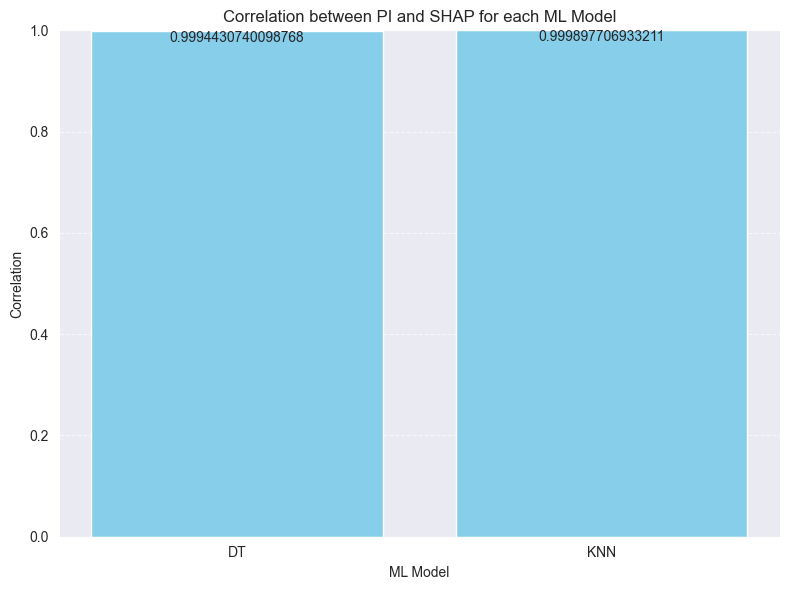

In [4]:
# ---- Executing XAI methods and showing the levels of agreement ----

# computing features relevance for DT with Permutation Importance
monitor_tic()
f_relevance_PI_DT = PI(x_test, y_test, DT)
time_PI_DT, cpu_percent_PI_DT = monitor_toc()
energy_consumed_PI_DT = simulate_energy_consumption(time_PI_DT, cpu_percent_PI_DT)

# computing features relevance for DT with SHAP
monitor_tic()
f_relevance_SHAP_DT = SHAP(x_test, y_test, DT)
time_SHAP_DT, cpu_percent_SHAP_DT = monitor_toc()
energy_consumed_SHAP_DT = simulate_energy_consumption(time_SHAP_DT, cpu_percent_SHAP_DT)

# computing features relevance for KNN with Permutation Importance
monitor_tic()
f_relevance_PI_KNN = PI(x_test, y_test, KNN)
time_PI_KNN, cpu_percent_PI_KNN = monitor_toc()
energy_consumed_PI_KNN = simulate_energy_consumption(time_PI_KNN, cpu_percent_PI_KNN)

# computing features relevance for KNN with SHAP
monitor_tic()
f_relevance_SHAP_KNN = SHAP(x_test, y_test, KNN)
time_SHAP_KNN, cpu_percent_SHAP_KNN = monitor_toc()
energy_consumed_SHAP_KNN = simulate_energy_consumption(time_SHAP_KNN, cpu_percent_SHAP_KNN)


# Creating dataframe with the results of feature relevance
data = {
    'ML model': ['DT', 'DT', 'KNN', 'KNN'],
    'XAI method': ['PI', 'SHAP', 'PI', 'SHAP'],
    'Features Relevance': [np.round(f_relevance_PI_DT, 3), np.round(f_relevance_SHAP_DT, 3), np.round(f_relevance_PI_KNN, 3), np.round(f_relevance_SHAP_KNN, 3)]
}
df_agreement = pd.DataFrame(data)

# Plotting correlations
print(df_agreement)
# Compute correlation for each ML model separately
correlation_results = {}
for model, group in df_agreement.groupby('ML model'):
    # Extract 'PI' and 'SHAP' arrays for the model
    pi_array = group[group['XAI method'] == 'PI']['Features Relevance'].iloc[0]
    shap_array = group[group['XAI method'] == 'SHAP']['Features Relevance'].iloc[0]
    # Compute correlation
    correlation_results[model] = np.corrcoef(pi_array, shap_array)[0, 1]

plt.figure(figsize=(8, 6))
plt.bar(correlation_results.keys(), correlation_results.values(), color='skyblue')
plt.xlabel('ML Model')
plt.ylabel('Correlation')
plt.title('Correlation between PI and SHAP for each ML Model')
plt.ylim(0, 1)  # Set y-axis limits to the range [-1, 1]
plt.grid(axis='y', linestyle='--', alpha=0.7)
# plt.xticks(rotation=45)
for model, correlation in correlation_results.items():
    plt.text(model, correlation, f'{correlation}', ha='center', va='top')

# Show plot
plt.tight_layout()
plt.show()

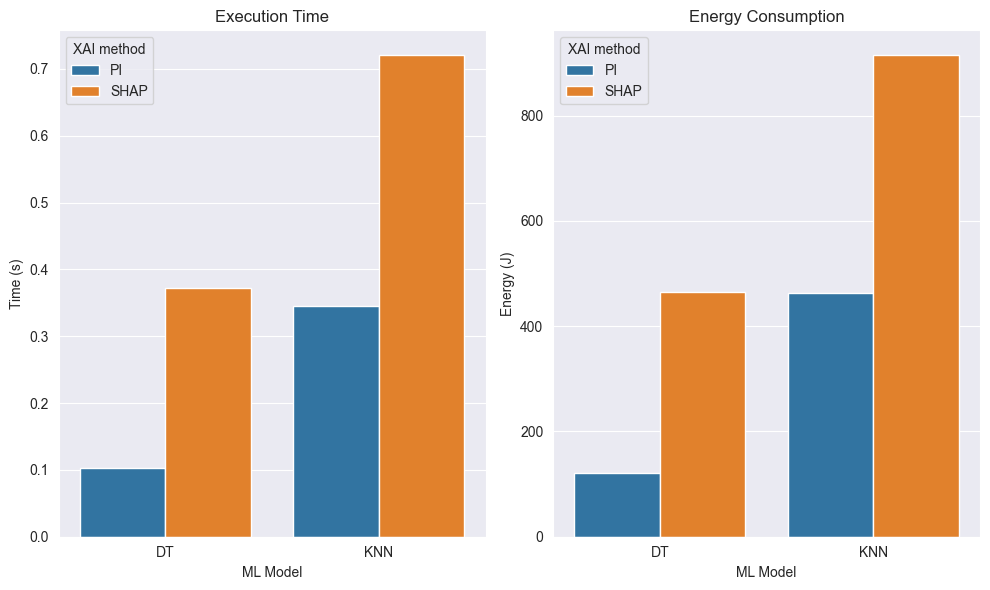

In [5]:
# ---- Showing the XAI costs ----

data = {
    'ML model': ['DT', 'DT', 'KNN', 'KNN'],
    'XAI method': ['PI', 'SHAP', 'PI', 'SHAP'],
    'Execution time': [time_PI_DT, time_SHAP_DT, time_PI_KNN, time_SHAP_KNN],
    'Energy consumption': [energy_consumed_PI_DT, energy_consumed_SHAP_DT, energy_consumed_PI_KNN, energy_consumed_SHAP_KNN],
}
df_costs = pd.DataFrame(data)

# Plotting costs
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
sns.barplot(data=df_costs, x='ML model', y='Execution time', hue='XAI method')
plt.title('Execution Time')
plt.xlabel('ML Model')
plt.ylabel('Time (s)')
plt.subplot(1, 2, 2)
sns.barplot(data=df_costs, x='ML model', y='Energy consumption', hue='XAI method')
plt.title('Energy Consumption')
plt.xlabel('ML Model')
plt.ylabel('Energy (J)')
plt.tight_layout()
plt.show()
